# Find and load Sentinel 2 ARD Data using load_ard
This notebook uses the load_ard (load Analysis Ready Data) function to find and load Sentinel 2 data. The notebook also calulates the geomedian for the loaded data.



In [1]:
#What can be deleted here?
%matplotlib inline

import warnings; warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
import datacube
import fnmatch
import os
import pandas as pd
import geopandas as gpd

#get the DEA version of the plotting functions
import sys
sys.path.append(os.path.abspath('/g/data/r78/DPIPWE_lm/repos/dea-notebooks/Scripts'))
from dea_datahandling import load_ard
import dea_plotting
from dea_plotting import rgb
from datacube_stats.statistics import GeoMedian
from datacube.helpers import ga_pq_fuser
from datacube.storage import masking
from datacube.helpers import write_geotiff
from datacube.drivers.netcdf import write_dataset_to_netcdf
import xarray as xr

#Specify output directory
outputdir = '/g/data/r78/DPIPWE_lm/output_data/'
if not os.path.exists(outputdir):
    print("output directory doesn't exist")
    exit()

In [2]:
# Connect to datacube containing Sentinel 2 data
dc_sentinel2 = datacube.Datacube(app='Using_load_ard')


# Temporary solution to account for Collection 3 data being in a different
# database on the NCI (is this landsat only??)
try:
    dc_landsat = datacube.Datacube(app='Using_load_ard', env='c3-samples')
except:
    dc_landsat = datacube.Datacube(app='Using_load_ard')
    
#dc = datacube.Datacube(app='load_sentinel_example')

In [7]:
# Create a reusable query (can change resolution and/or bands here if needed)
query = {
    'lat': (-40.188, -40.214),
    'lon': (148.228, 148.268),
    'time': ('2019-01', '2019-03'), # Months or day can be specified here
    'measurements': ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir_1'],
    'output_crs': 'EPSG:3577',
    'resolution': (-20, 20),
    'group_by': 'solar_day'
}

In [8]:
# Load available data from both Sentinel 2 satellites
ds = load_ard(dc=dc_sentinel2,
              products=['s2a_ard_granule', 's2b_ard_granule'],
              **query)

# Print output data
print(ds)

Loading s2a_ard_granule data
    Applying pixel quality/cloud mask
    Applying invalid data mask
    Applying contiguity mask
Loading s2b_ard_granule data
    Applying pixel quality/cloud mask
    Applying invalid data mask
    Applying contiguity mask
Combining and sorting data
    Returning 18 observations 
<xarray.Dataset>
Dimensions:      (time: 18, x: 191, y: 164)
Coordinates:
  * y            (y) float64 -4.484e+06 -4.484e+06 ... -4.487e+06 -4.487e+06
  * x            (x) float64 1.4e+06 1.4e+06 1.4e+06 ... 1.404e+06 1.404e+06
  * time         (time) datetime64[ns] 2019-01-05T00:02:41.024000 ... 2019-03-31T00:02:39.024000
Data variables:
    nbart_blue   (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_green  (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_red    (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_nir_1  (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    crs:      EPSG:3577

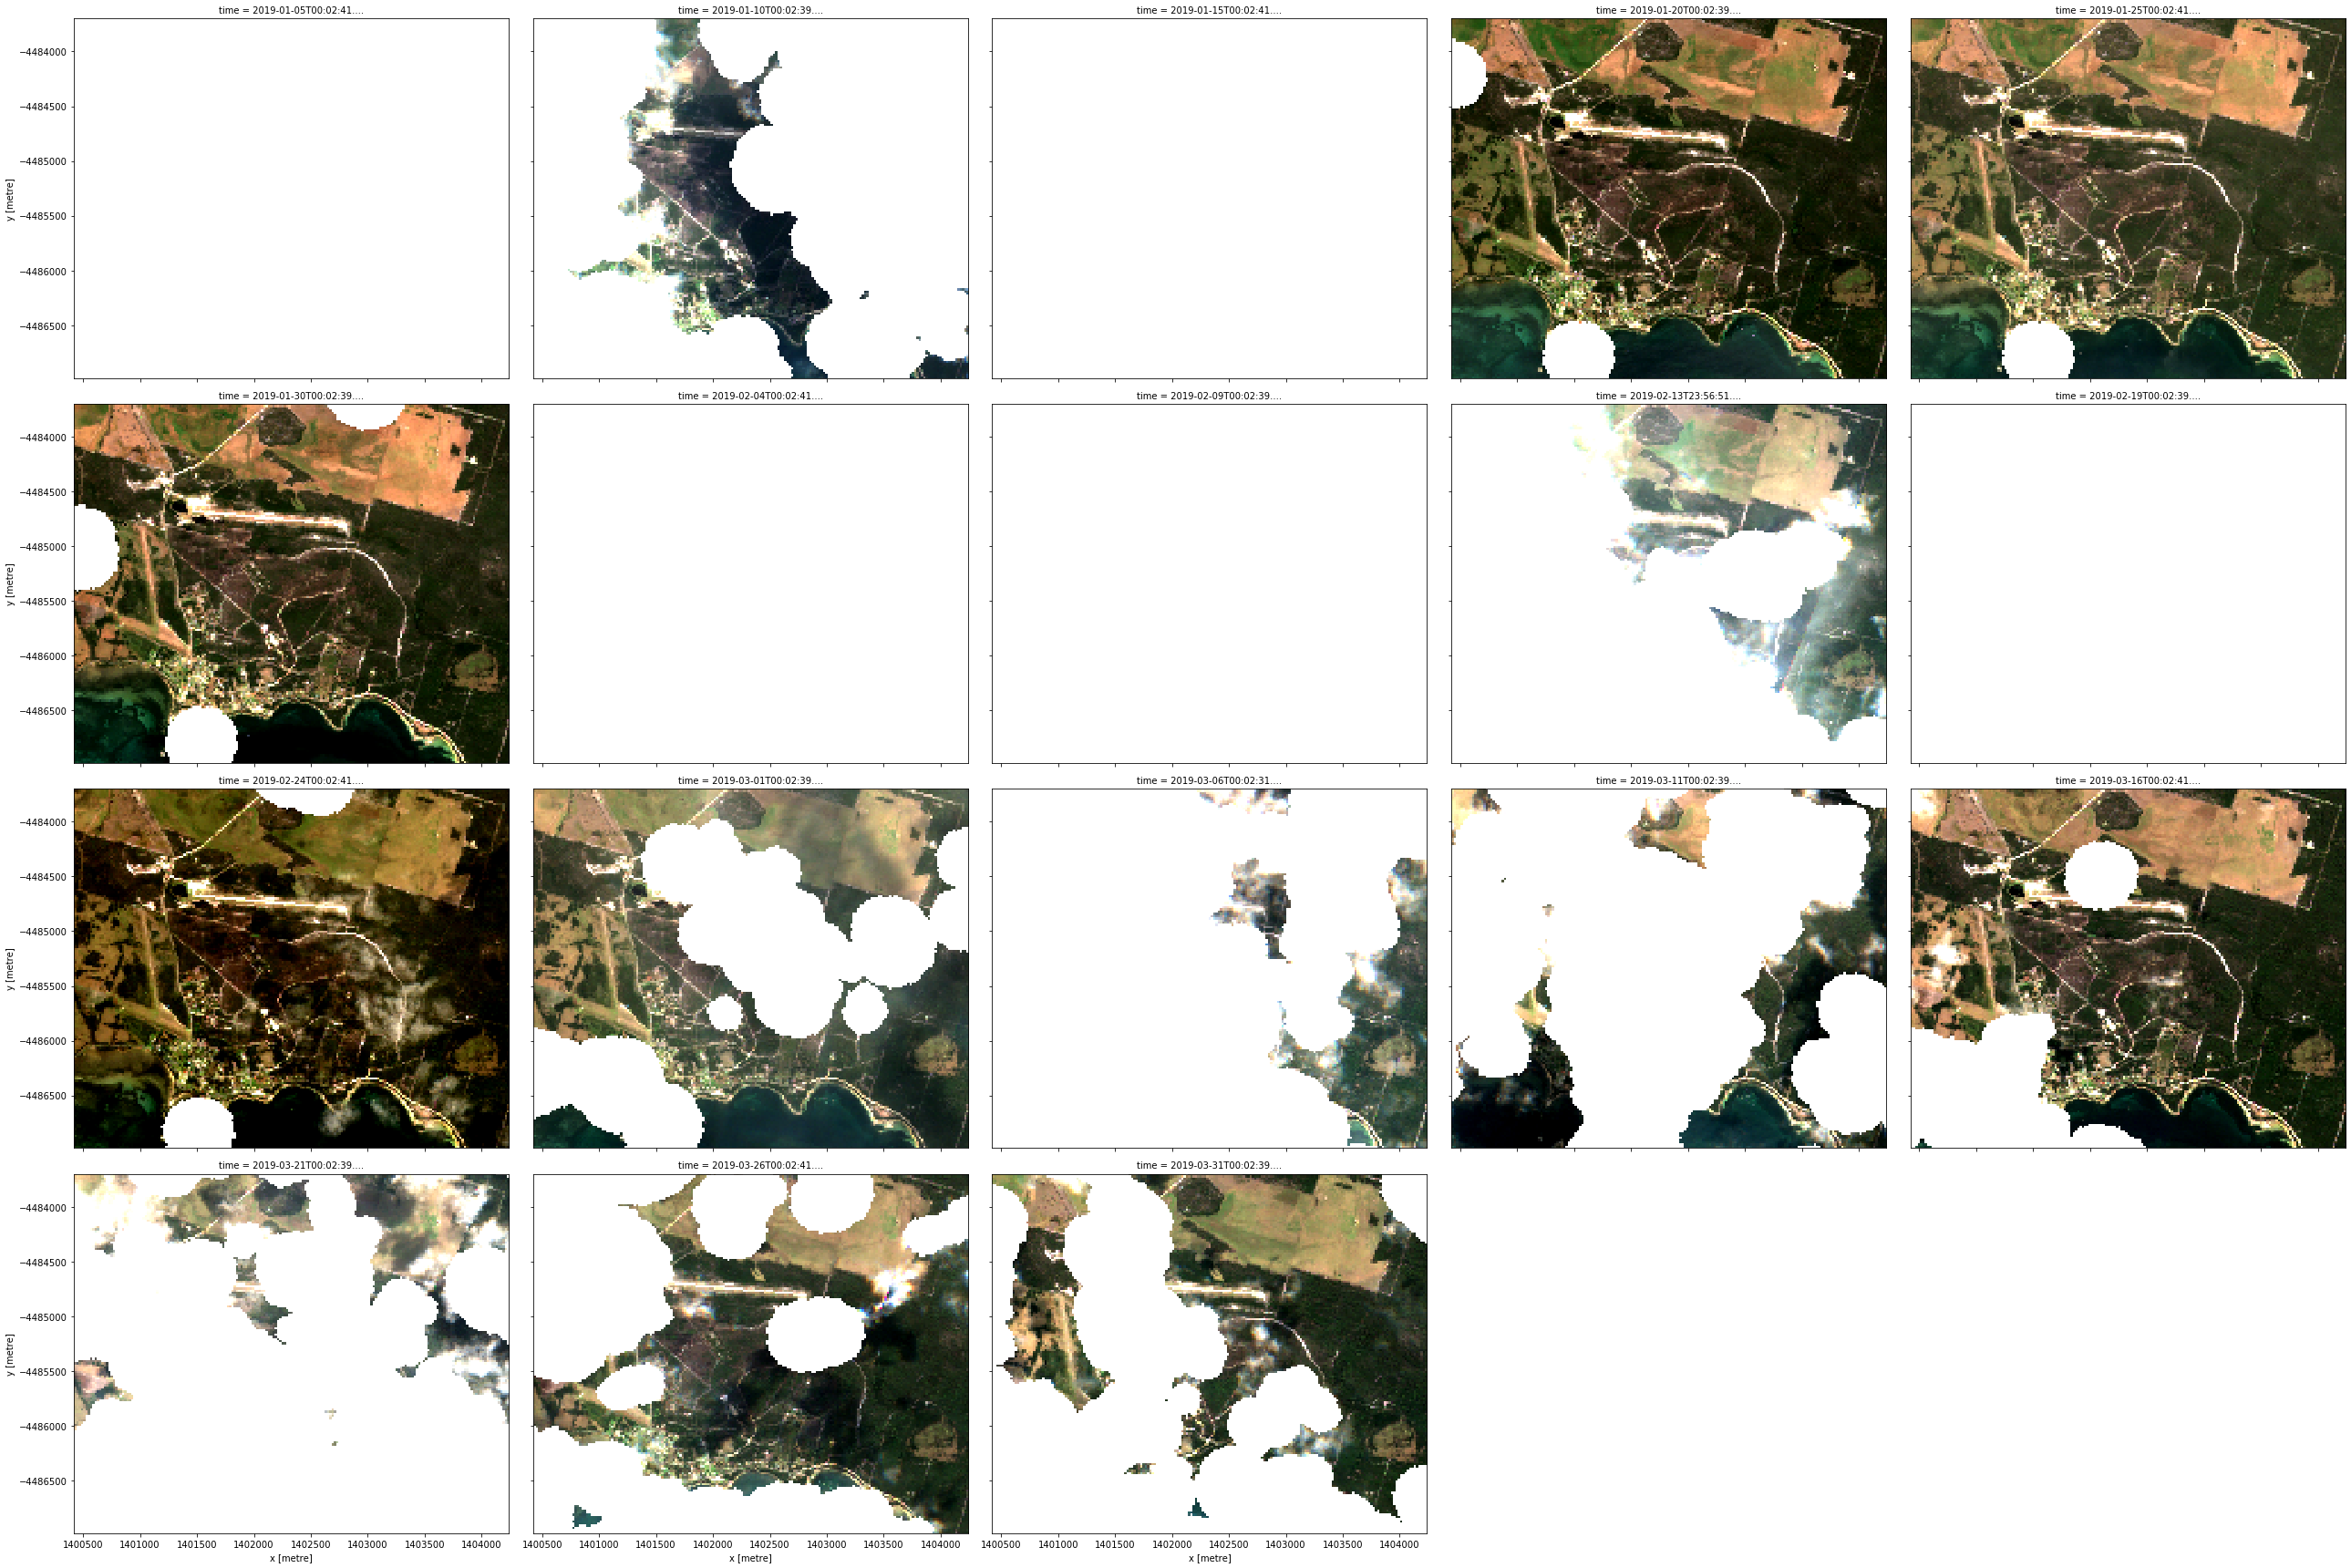

In [9]:
# Plot single observation
#ds.isel(time=6).nbart_nir_1.plot() # Plot time slice 6
#plt.show()

# This will plot all time slices so can take a while for large cubes
rgb(ds, percentile_stretch=(0.05, 0.95), col='time', col_wrap=5)

# Monthly Filter and Geomedian Creation

The cells below run through the process used to filter an existing S2 datacube by month and then produce
a geomedian image. This type of process is useful where only dry season images are required e.g. for producing
dry season composite images.

In [ ]:
# function to return months of interest (cm = composite month)
def is_cm(month):
    return (month >= 11) | (month <= 4)

In [ ]:
# extract just the months of interest
ds_cm = ds.sel(time=is_cm(ds['time.month']))

ds_cm['time.month'] #take a look at what months we have...

In [ ]:
ds_cm

In [ ]:
# Compute geomedian here is necessary - either for dataset or subset months
ds_cm_gm = GeoMedian().compute(ds_cm)

In [ ]:
ds_cm_gm

In [ ]:
# Plot geomedian image
rgb(ds_cm_gm, percentile_stretch=(0.05, 0.95))

In [ ]:
# Here we can export the geomedian
# There is no time dimension so the next line can be ignored
#rgb_tiff = ds.isel(time=1)

# Write multi-band GeoTIFF to a location
write_geotiff(outputdir + 'Sent2_gomedian.tif', ds_cm_gm)